In [1]:
from matplotlib import pyplot as plt
import pickle
import os
import scipy
import importlib

from scipy import signal
import numpy as np
import emcee
import lmfit
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
 

In [2]:
import prpatt

In [4]:
datadir='/storage/qbo/users/bensan/'

Open xarray datasets

In [5]:
mdlslr=pickle.load( open( datadir+"colab_4xco2/mdls.pkl", "rb" ))
nmlr=len(mdlslr)

In [8]:
#CMIP6
ds_4x = xr.open_dataset(datadir+"colab_4xco2/abrupt-4xCO2.nc")
ds_1pc = xr.open_dataset(datadir+"colab_4xco2/1pctCO2.nc")
ds_hist = xr.open_dataset(datadir+"colab_4xco2/historical.nc")

ds_cnt = xr.open_dataset(datadir+"colab_4xco2/piControl.nc")
ds_r85 = xr.open_dataset(datadir+"colab_4xco2/ssp585.nc")
ds_r26 = xr.open_dataset(datadir+"colab_4xco2/ssp126.nc")

#longrunmip
dslr_4x = xr.open_dataset(datadir+"colab_4xco2/lrmip2_4x.nc")
dslr_cnt = (datadir+"colab_4xco2/lrmip2_cnt.nc")





In [9]:
if 0:
  ds_4x_anom=prpatt.make_anom(ds_4x,ds_cnt)
  ds_4x_anom.to_netcdf(datadir+'colab_4xco2/a4xanom.nc')
  ds_1pc_anom=prpatt.make_anom(ds_1pc,ds_cnt)
  ds_1pc_anom.to_netcdf(datadir+'colab_4xco2/1pcanom.nc')

else:
  ds_4x_anom=xr.open_dataset(datadir+'colab_4xco2/a4xanom.nc')
  ds_1pc_anom=xr.open_dataset(datadir+'colab_4xco2/1pcanom.nc')

In [10]:
X=ds_4x_anom.tas[0,:150,:,:]


In [11]:
(ts,out,us,orgeof)=prpatt.get_timescales(X,[5,40,10000])
ts

[1.3668880356711046, 32.62736784540214, 39999.87566457205]

In [12]:
np.tile(orgeof['s'].T,(150,1)).shape
orgeof['u'].shape

(150, 3)

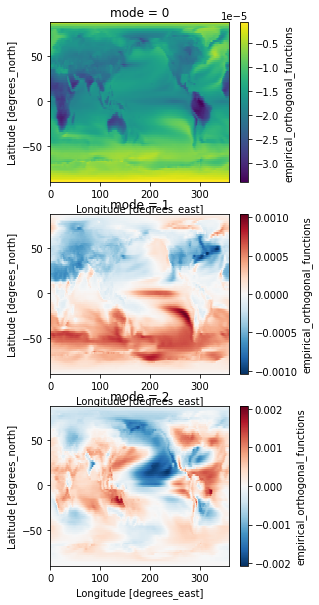

In [13]:
p,ax=plt.subplots(3,1)
p.set_size_inches(4,10)

orgeof['v'][0,:,:].plot(ax=ax[0])
orgeof['v'][1,:,:].plot(ax=ax[1])
orgeof['v'][2,:,:].plot(ax=ax[2])


150

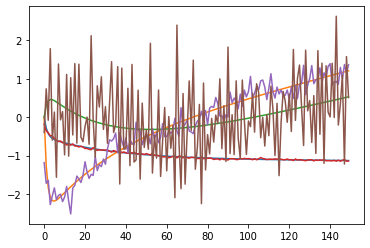

In [14]:
plt.plot(us)
plt.plot(orgeof['u'])
orgeof['u'].shape[0]

In [15]:
Xrp=prpatt.recon(orgeof)
Xrs=prpatt.rmodel(orgeof,us)



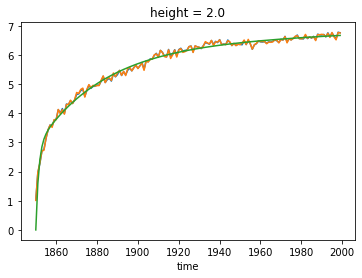

In [16]:
X.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xrp.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xrs.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()



Text(0.5, 1.0, 'actual year 150 abrupt4x')

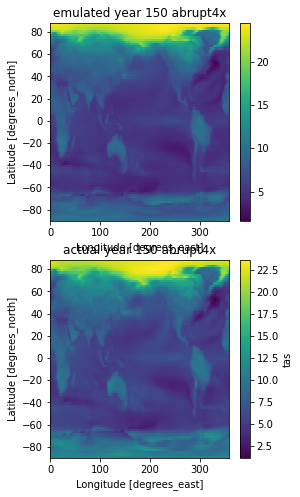

In [17]:
p,ax=plt.subplots(2,1)
p.set_size_inches(4,8)
Xrs[-1,:,:].plot(ax=ax[0])
ax[0].set_title('emulated year 150 abrupt4x')
X[-1,:,:].plot(ax=ax[1])
ax[1].set_title('actual year 150 abrupt4x')


In [18]:
f=np.arange(0,150)*5.35*np.log(1.01)
Xu=prpatt.imodel_eof(out.params, f)
Xf=prpatt.imodel_filter(out.params,f)
Xsim=prpatt.rmodel(orgeof,Xf)

Text(0.5, 1.0, '1pctCO2 forcing timeseries')

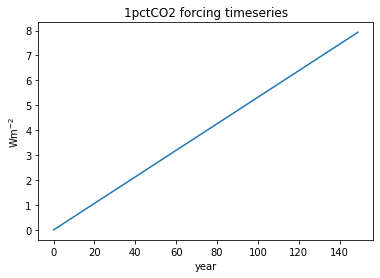

In [19]:
plt.plot(f)
plt.ylabel(r'Wm$^{-2}$')
plt.xlabel('year')
plt.title('1pctCO2 forcing timeseries')

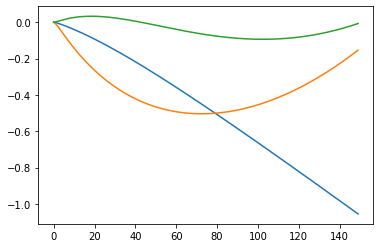

In [20]:
plt.plot(Xf[:])
#plt.plot(Xu[:],'--')

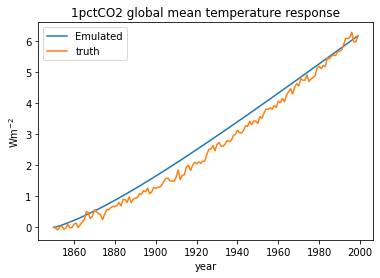

In [21]:
p1=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xact=ds_1pc_anom.tas[0,:150,:,:]

p2=Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
plt.ylabel(r'Wm$^{-2}$')
plt.xlabel('year')
plt.title('1pctCO2 global mean temperature response')
plt.legend((p1[0],p2[0]),['Emulated','truth'])

Text(0.5, 1.0, 'actual year 150 1pctCO2')

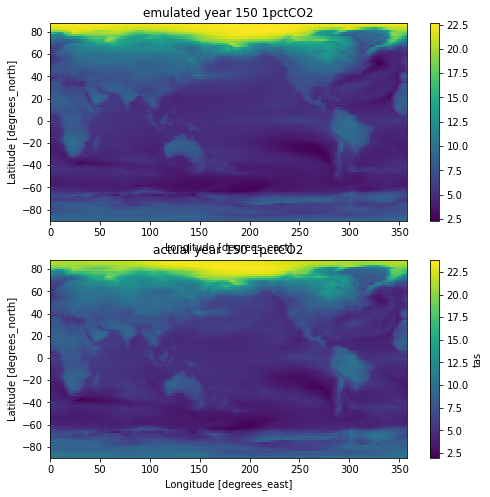

In [22]:
p,ax=plt.subplots(2,1)
p.set_size_inches(8,8)
Xsim[-1,:,:].plot(ax=ax[0])
ax[0].set_title('emulated year 150 1pctCO2')
Xact[-1,:,:].plot(ax=ax[1])
ax[1].set_title('actual year 150 1pctCO2')


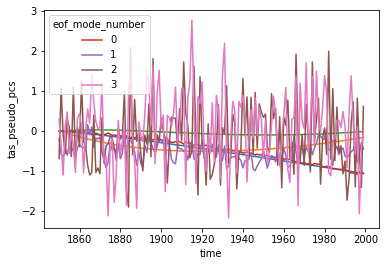

In [23]:
solver = Eof(X,center=False,weights=prpatt.wgt2(X))

Xu.plot.line(x='time')
ua=solver.projectField(Xact,neofs=4,eofscaling=1)
ua.plot.line(x='time')


In [24]:

outscl=prpatt.adjust_timescales(X,Xact,out.params,ts,f)
outscl

In [25]:
Xscl=prpatt.imodel_filter_scl(outscl.params,out.params,f)
Xsimscl=prpatt.rmodel(orgeof,Xscl)

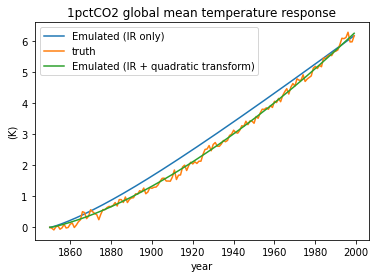

In [26]:
p1=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xact=ds_1pc_anom.tas[0,:150,:,:]

p2=Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
p3=Xsimscl.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()

plt.ylabel(r'(K)')
plt.xlabel('year')
plt.title('1pctCO2 global mean temperature response')
plt.legend((p1[0],p2[0],p3[0]),['Emulated (IR only)','truth','Emulated (IR + quadratic transform)'])

In [29]:
Xu1=prpatt.imodel_eof(outscl.params, f)
Xsim1=prpatt.rmodel(orgeof,Xu)

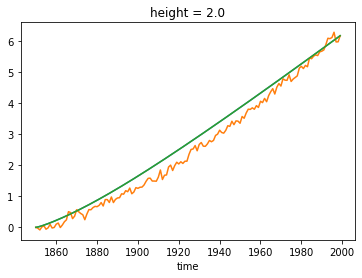

In [30]:
Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xsim1.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()


In [31]:
inma=prpatt.imodel_filter(out.params, f, F0=7.41, y0=1850)

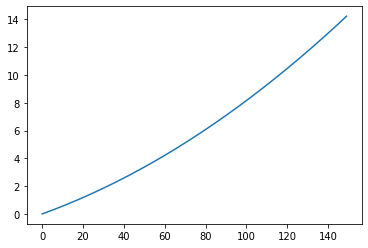

In [32]:
plt.plot(f+np.square(f)/10)

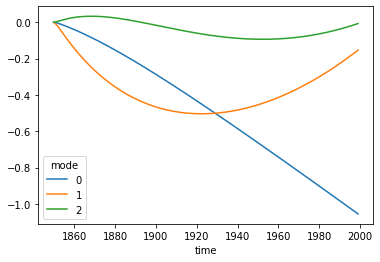

In [33]:
inma.plot.line(x='time')